# Policy sweep plotting (minimal)

Goal: Load epoch-level aggregates and produce per-learning-rate plots for a chosen policy class.
- X axis: epoch
- Y axis: mean reward (per-epoch average across trajectories)
- One trace per (policy_class, run_id) within each learning-rate facet

This cleaned-up notebook imports small helpers and focuses on the end result: per-learning-rate plots.

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from utils.plot_utils import (
    load_epoch_agg_multi,
    filter_epoch_df,
    extract_fields,
    plot_epoch_rewards,
)

In [2]:
# Inputs (keep minimal)
# One or more result directories (directory passed to --output-dir when running experiments)
DATA_DIRS = [
    "results/grid_sweep_top/parquet",
]

# Note:
# Remaining options are now passed inline to the helper functions in later cells
# to reduce global state and make chaining explicit.

In [3]:
# Load all epoch aggregate parquet files from one or more directories

df = load_epoch_agg_multi(DATA_DIRS)
if df.empty:
    print(f"No parquet files found under: {DATA_DIRS}")
else:
    display(df.head())
    print('Rows:', len(df))

,run_id,config_hash,label,setup,num_days,num_trajs,num_epochs,epoch,agent_name,policy_class,policy_params_json,mean_reward,std_reward,n_trajs,source_dir
0,17ceb0f2-2845-48af-9974-660b07b77c8f,a4e21ce2e05786adf1ae350487544265a3d0fd2e042dc0...,grid_sweep_top-i18,setup_1,1,200,3000,0,agent1,AC_TD_Gaussian_v3_MarketEnv_Continuous,"{""auction_item_spec_ids"": [2], ""budget_per_rea...",0.241132,4.973467,200,results/grid_sweep_top/parquet
1,17ceb0f2-2845-48af-9974-660b07b77c8f,a4e21ce2e05786adf1ae350487544265a3d0fd2e042dc0...,grid_sweep_top-i18,setup_1,1,200,3000,0,agent2,FixedBidPolicy,"{""bid_per_item"": 5, ""total_limit"": 5}",0.000000,0.000000,200,results/grid_sweep_top/parquet
2,17ceb0f2-2845-48af-9974-660b07b77c8f,a4e21ce2e05786adf1ae350487544265a3d0fd2e042dc0...,grid_sweep_top-i18,setup_1,1,200,3000,1,agent1,AC_TD_Gaussian_v3_MarketEnv_Continuous,"{""auction_item_spec_ids"": [2], ""budget_per_rea...",0.346203,4.510103,200,results/grid_sweep_top/parquet
3,17ceb0f2-2845-48af-9974-660b07b77c8f,a4e21ce2e05786adf1ae350487544265a3d0fd2e042dc0...,grid_sweep_top-i18,setup_1,1,200,3000,1,agent2,FixedBidPolicy,"{""bid_per_item"": 5, ""total_limit"": 5}",0.000000,0.000000,200,results/grid_sweep_top/parquet
4,17ceb0f2-2845-48af-9974-660b07b77c8f,a4e21ce2e05786adf1ae350487544265a3d0fd2e042dc0...,grid_sweep_top-i18,setup_1,1,200,3000,2,agent1,AC_TD_Gaussian_v3_MarketEnv_Continuous,"{""auction_item_spec_ids"": [2], ""budget_per_rea...",1.355987,4.517697,200,results/grid_sweep_top/parquet


Rows: 156000


Setup: setup_1 | Agent: agent1 | Label prefix: None
Learning rates found: [5e-07, 5e-06]


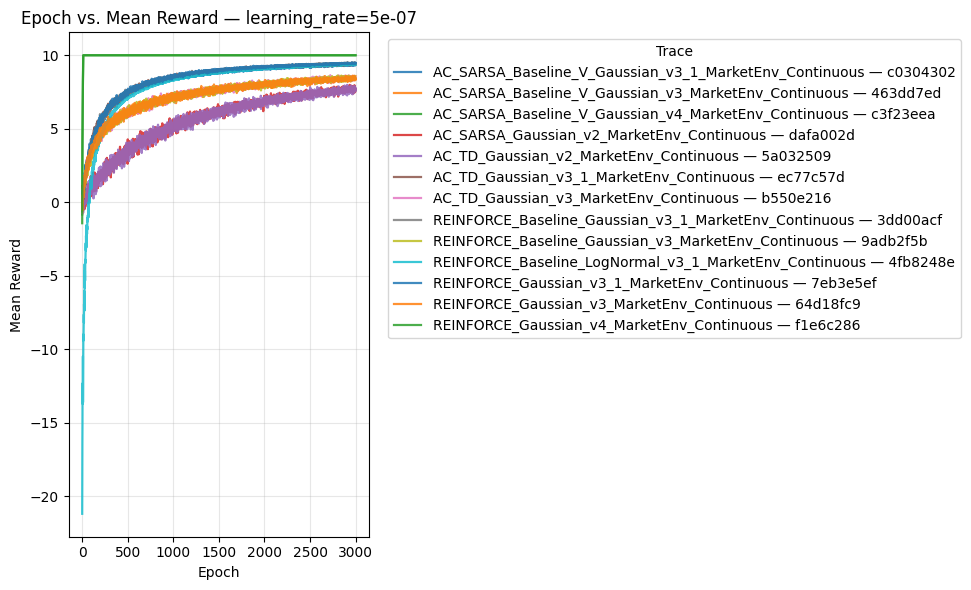

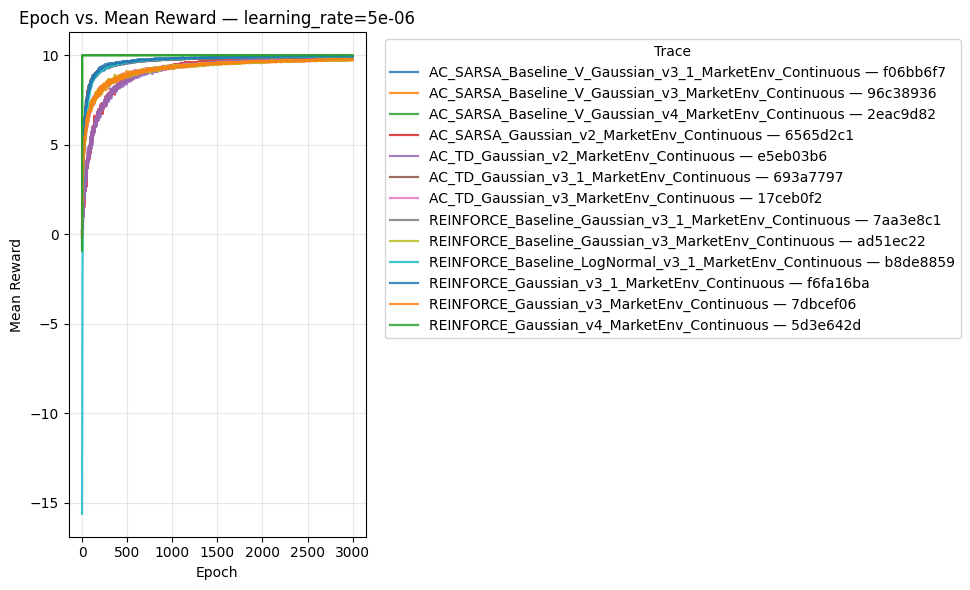

In [ ]:
# Extract learning_rate into its own column and plot, grouped by learning rate (all policies)
setup = "setup_1"           # e.g., 'setup_1'
agent_name = "agent1"      # e.g., 'agent1'
label = None           # e.g., 'grid_sweep_top' (prefix match)

# Extract the learning_rate field into its own column
filtered = extract_fields(
    df,
    nested_column="policy_params_json",
    fields="learning_rate",
    new_column_name="learning_rate",
)

# Apply filters (setup/agent exact), and label as a prefix filter
base = filter_epoch_df(filtered, setup=setup, agent_name=agent_name, label=None)
if label is not None and 'label' in base.columns:
    base = base[base['label'].astype(str).str.startswith(label, na=False)]

# List the unique learning rates present after filtering
vals = sorted(v for v in base['learning_rate'].unique() if pd.notna(v))
print('Setup:', setup, '| Agent:', agent_name, '| Label prefix:', label)
print('Learning rates found:', vals)

# Plot one figure per learning rate (all policies included in each plot)
for lr in vals:
    sub = base[base['learning_rate'] == lr]
    if sub.empty:
        print("Warning: No data for learning_rate =", lr)
        continue
    fig, ax = plot_epoch_rewards(sub, title=f"Epoch vs. Mean Reward — learning_rate={lr}")
    display(fig)
    plt.close(fig)